**Created By:**
*   Yash Mahajan
*   Deep Mehta
*   Joel Miranda
*   Ron Pinto

In [ ]:
!pip install tensorflow_hub

In [ ]:
# import libraries
from google.colab import drive
import json
from PIL import Image
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dropout, Dense, MaxPooling2D, Flatten, Input, BatchNormalization
from keras import Model
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip file from drive
if not os.path.isdir('flower_dataset'):
  !unzip drive/My\ Drive/ML-Project/Dataset/flower_dataset.zip

# **1]  Data Exploration**

In [ ]:
data_dir = 'flower_dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
name_json = data_dir + '/cat_to_name.json'

In [ ]:
# Get classes of the flower species
with open(name_json, 'r') as f:
  category_to_name = json.load(f)

print('Number Of Classes:', len(category_to_name), '\n')
print(category_to_name)

Number Of Classes: 102 

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved

In [ ]:
# Count no. of images of each category in each split
train_num = []
test_num = []
category_names = []

for label in os.listdir(train_dir):
    category_names.append(category_to_name[label])
    train_num.append(len(os.listdir(train_dir + '/' + label)))
    test_num.append(len(os.listdir(test_dir + '/' + label)))

# Create a dataframe
category_names_df = pd.DataFrame({
    'Category': category_names,
    'Train_num': train_num,
    'Test_num': test_num})

In [ ]:
category_names_df

,Category,Train_num,Test_num
0,spear thistle,44,3
1,buttercup,57,5
2,marigold,61,3
3,peruvian lily,65,6
4,monkshood,41,2
...,...,...,...
97,tree poppy,51,4
98,poinsettia,73,11
99,oxeye daisy,38,3
100,colt's foot,73,9


In [ ]:
# Amount of data in each split
train_samples = sum(category_names_df['Train_num'])
test_samples = sum(category_names_df['Test_num'])
total_samples = train_samples + test_samples
print('Data samples in the Training set:', train_samples)
print('Data samples in the Test set:', test_samples)
print('Train-Test split ratio: ', round((train_samples/total_samples)*100),':', round((test_samples/total_samples)*100))

Data samples in the Training set: 6552
Data samples in the Test set: 819
Train-Test split ratio:  89 : 11


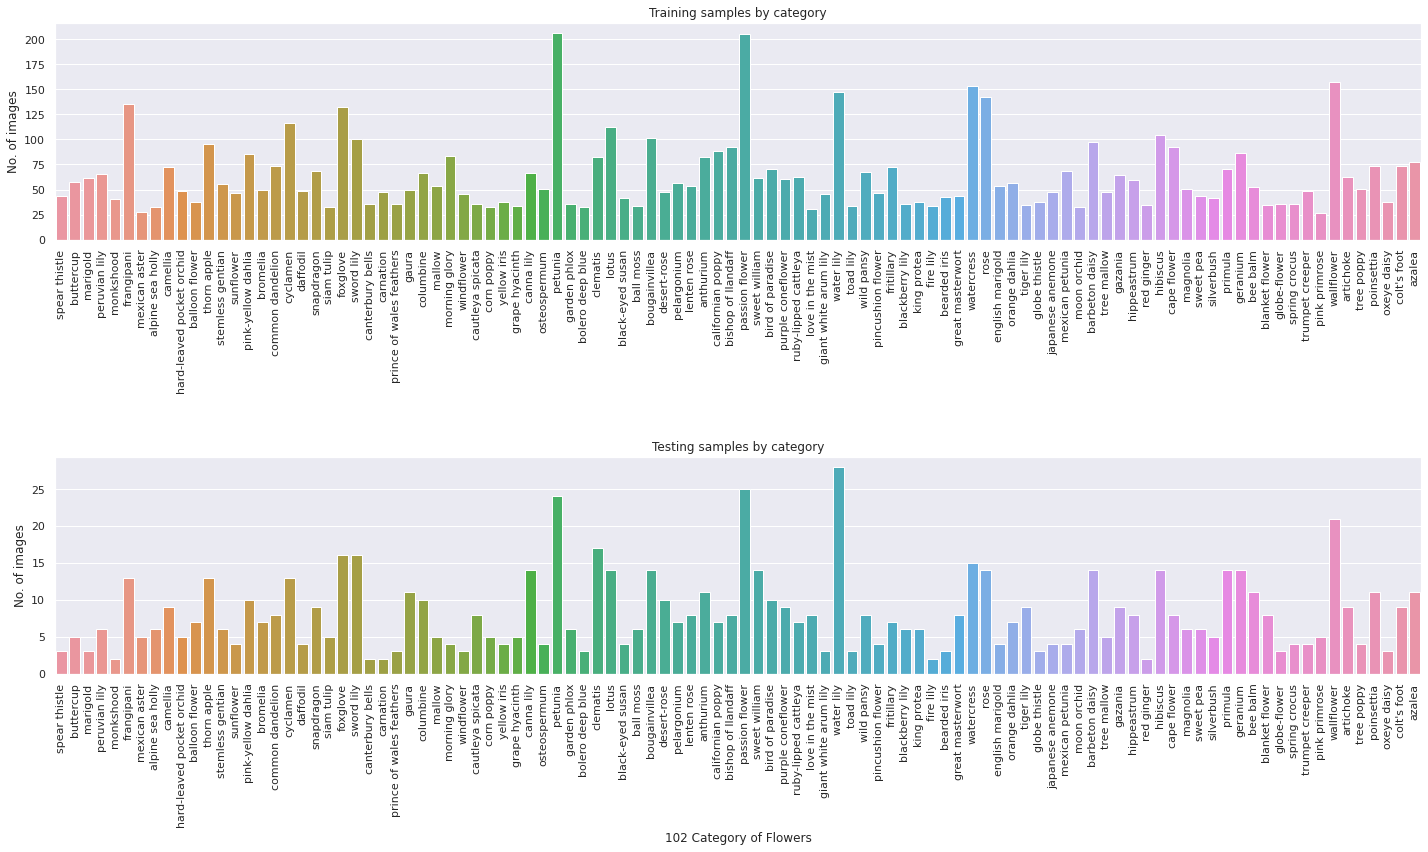

In [ ]:
# Distribution of training samples
category_names_df.set_index('Category')

plt.figure(figsize=(20,12))
sns.set(style='darkgrid')
plt.title('Training and testing samples by category')

plt.subplot(211)
sns.barplot(data=category_names_df, x='Category', y='Train_num')
plt.xticks(rotation=90)
plt.ylabel('No. of images')
plt.xlabel('')
plt.title('Training samples by category')
plt.tight_layout()

plt.subplot(212)
sns.barplot(data=category_names_df, x='Category', y='Test_num')
plt.xticks(rotation=90)
plt.ylabel('No. of images')
plt.xlabel('102 Category of Flowers')
plt.title('Testing samples by category')
plt.tight_layout()

plt.subplots_adjust(hspace=1)

plt.show()

In [ ]:
# import shutil
# shutil.rmtree('flower_dataset')

# **2]  Data Preprocessing**
Set appropriate folder names

In [ ]:
# Rename folders according to flower class
def renameFolders(dir):
  for folderName in os.listdir(dir):
    if folderName.isnumeric():
      flowerClass = category_to_name[folderName]
      os.rename(os.path.join(dir, folderName), os.path.join(dir, flowerClass))

In [ ]:
renameFolders(train_dir)
renameFolders(test_dir)
renameFolders(valid_dir)

### **2.1]  Data Augmentation**

1.   Train image preprocessing

In [ ]:
# Initialize Keras ImageDataGenerator to read training images from folder
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rotation_range=10)

train_datagen_batches = train_datagen.flow_from_directory(directory=train_dir, 
                                                            target_size=(299,299),
                                                            batch_size=32,
                                                            class_mode='categorical')

Found 6552 images belonging to 102 classes.


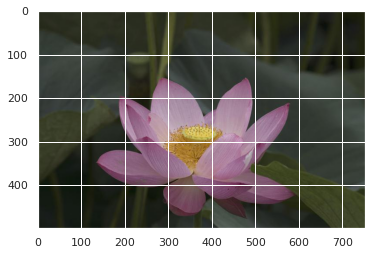

In [ ]:
# demonstrate data augmentation for a random image
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# choose random image    
chosen_image = random.choice(os.listdir(train_dir+'/lotus'))
image_path = train_dir+'/lotus/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)   #reading image and expanding dims
plt.imshow(image[0])

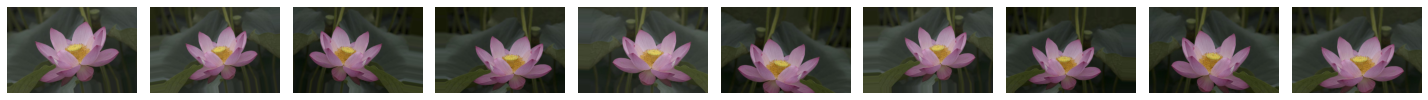

In [ ]:
# generate batch of augmented images
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]   #take 10 samples from the batch 
plotImages(aug_images)

2.   Test Image Preprocessing



In [ ]:
# Initialize Keras ImageDataGenerator to read testing images from folder
test_datagen = ImageDataGenerator(rescale=1./255)

test_datagen_batches = test_datagen.flow_from_directory(directory=test_dir, 
                                                            target_size=(299,299),
                                                            batch_size=819,
                                                            class_mode='categorical')

Found 819 images belonging to 102 classes.


3.   Validation Image Preprocessing



In [ ]:
# Initialize Keras ImageDataGenerator to read validation images from folder
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen_batches = valid_datagen.flow_from_directory(directory=valid_dir, 
                                                            target_size=(299,299),
                                                            batch_size=32,
                                                            class_mode='categorical')

Found 818 images belonging to 102 classes.


In [ ]:
x_test, y_test=test_datagen_batches.next()

# **3]  CNN Model Development**

In [ ]:
# Force stop epoch is accuracy decreases
EARLY_STOPPING_TRAIN_ACCURACY = 0.995
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > EARLY_STOPPING_TRAIN_ACCURACY):
            print(
                f"\nEarly stopping at {logs.get('accuracy'):.4f} > {EARLY_STOPPING_TRAIN_ACCURACY}!\n")
            self.model.stop_training = True

### **3.1] Transfer Learning**
Using Inception v3 pre-trained model:  https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5

In [ ]:
# Use inception-v3 pretrained model and add few other layers

IMAGE_SIZE = (299, 299)
cnn_model = tf.keras.Sequential([
                hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5", 
                               input_shape=IMAGE_SIZE + (3,),
                               trainable=False),
                Dropout(0.3),
                Dense(102, activation='softmax')])

early_stop_callback = EarlyStoppingCallback()

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 22,011,782
Trainable params: 208,998
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# train model over 5 epochs 

history = cnn_model.fit(train_datagen_batches, 
                        epochs=5,
                        validation_data=valid_datagen_batches,
                        callbacks=[early_stop_callback])

Epoch 1/5
205/205 [==============================] - 218s 973ms/step - loss: 1.3828 - accuracy: 0.7457 - val_loss: 0.3353 - val_accuracy: 0.9535
Epoch 2/5
205/205 [==============================] - 190s 925ms/step - loss: 0.2672 - accuracy: 0.9531 - val_loss: 0.2105 - val_accuracy: 0.9609
Epoch 3/5
205/205 [==============================] - 188s 916ms/step - loss: 0.1734 - accuracy: 0.9670 - val_loss: 0.1676 - val_accuracy: 0.9707
Epoch 4/5
205/205 [==============================] - 188s 919ms/step - loss: 0.1149 - accuracy: 0.9799 - val_loss: 0.1370 - val_accuracy: 0.9719
Epoch 5/5
205/205 [==============================] - 189s 922ms/step - loss: 0.0946 - accuracy: 0.9846 - val_loss: 0.1367 - val_accuracy: 0.9694


### Score for test dataset

In [ ]:
test_score = cnn_model.evaluate(x_test,y_test)
print('Test data loss is: {:.2f}'.format(test_score[0]))
print('Test data accuracy is: {:.2f}%'.format(test_score[1]*100))

26/26 [==============================] - 11s 386ms/step - loss: 0.1592 - accuracy: 0.9585
Test data loss is: 0.16
Test data accuracy is: 95.85%


In [ ]:
# List of loss and accuracy for train and validation phase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.745726466178894, 0.9531440734863281, 0.9670329689979553, 0.9798534512519836, 0.9845848679542542]
[0.9535452127456665, 0.9608802199363708, 0.9706601500511169, 0.9718826413154602, 0.9694376587867737]
[1.3828251361846924, 0.267217755317688, 0.1733739972114563, 0.11488103866577148, 0.09459889680147171]
[0.3353050649166107, 0.21045757830142975, 0.16757440567016602, 0.13696005940437317, 0.13673973083496094]


### Examine the model to detect overfitting or underfitting

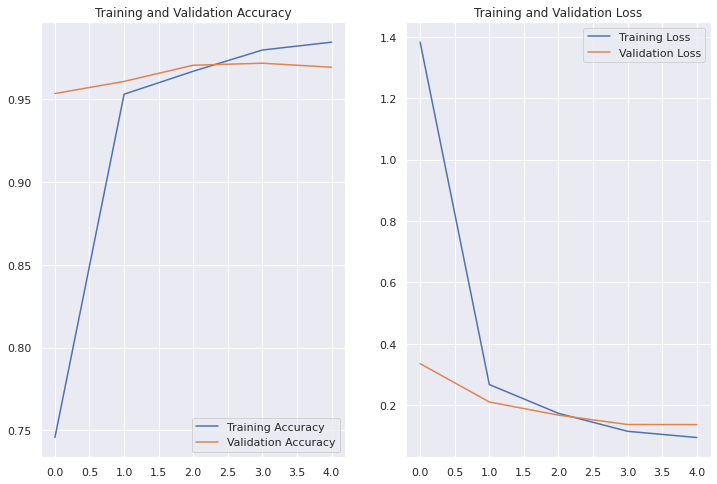

In [ ]:
epochs_range = range(5)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
actual = []
predictions = []
for idx, sample in enumerate(x_test):
  img, label = sample, y_test[idx]
  pred = cnn_model.predict(img.reshape(-1,299,299,3))
  for idx,val in enumerate(label):
    if val==1:
      actual.append(idx)
  predictions.append(np.argmax(pred))

In [ ]:
# generate performance metrics report
from sklearn.metrics import classification_report
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         9
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00         3
           8       1.00      0.91      0.95        11
           9       0.91      1.00      0.95        10
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         3
          15       0.93      0.93      0.93        14
          16       1.00      1.00      1.00         7
          17       1.00    

In [ ]:
# cnn_model.save('97.h5')

# **4]  Output Prediction**
#### Predicting flower species for test dataset

In [ ]:
train_datagen_batches.class_indices

{'alpine sea holly': 0,
 'anthurium': 1,
 'artichoke': 2,
 'azalea': 3,
 'ball moss': 4,
 'balloon flower': 5,
 'barbeton daisy': 6,
 'bearded iris': 7,
 'bee balm': 8,
 'bird of paradise': 9,
 'bishop of llandaff': 10,
 'black-eyed susan': 11,
 'blackberry lily': 12,
 'blanket flower': 13,
 'bolero deep blue': 14,
 'bougainvillea': 15,
 'bromelia': 16,
 'buttercup': 17,
 'californian poppy': 18,
 'camellia': 19,
 'canna lily': 20,
 'canterbury bells': 21,
 'cape flower': 22,
 'carnation': 23,
 'cautleya spicata': 24,
 'clematis': 25,
 "colt's foot": 26,
 'columbine': 27,
 'common dandelion': 28,
 'corn poppy': 29,
 'cyclamen': 30,
 'daffodil': 31,
 'desert-rose': 32,
 'english marigold': 33,
 'fire lily': 34,
 'foxglove': 35,
 'frangipani': 36,
 'fritillary': 37,
 'garden phlox': 38,
 'gaura': 39,
 'gazania': 40,
 'geranium': 41,
 'giant white arum lily': 42,
 'globe thistle': 43,
 'globe-flower': 44,
 'grape hyacinth': 45,
 'great masterwort': 46,
 'hard-leaved pocket orchid': 47,
 '

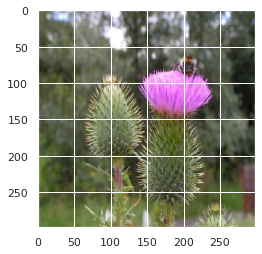

Actual value:  spear thistle
Predicted value:  spear thistle


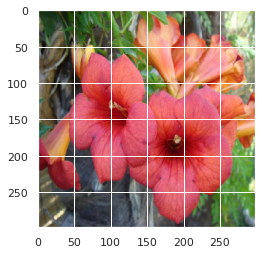

Actual value:  trumpet creeper
Predicted value:  trumpet creeper


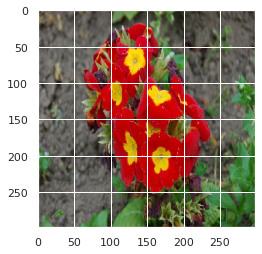

Actual value:  primula
Predicted value:  primula


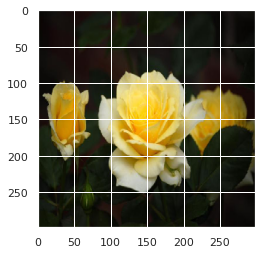

Actual value:  rose
Predicted value:  rose


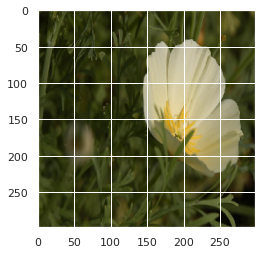

Actual value:  californian poppy
Predicted value:  californian poppy


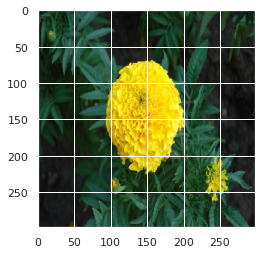

Actual value:  marigold
Predicted value:  marigold


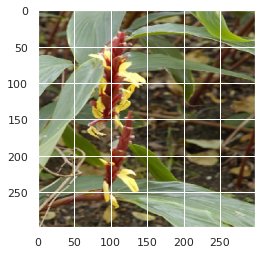

Actual value:  cautleya spicata
Predicted value:  cautleya spicata


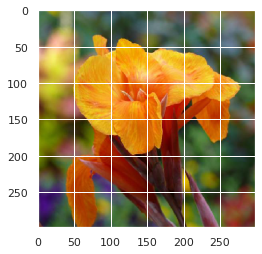

Actual value:  canna lily
Predicted value:  canna lily


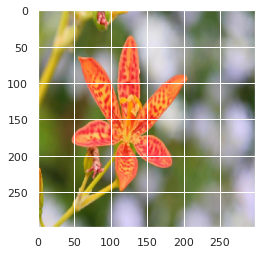

Actual value:  blackberry lily
Predicted value:  blackberry lily


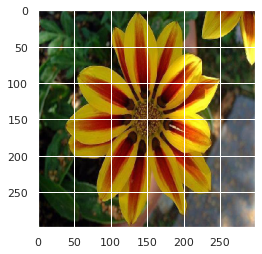

Actual value:  gazania
Predicted value:  gazania


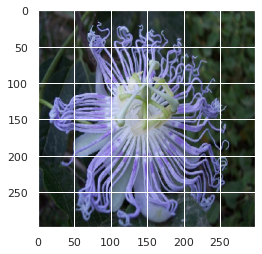

Actual value:  passion flower
Predicted value:  passion flower


In [ ]:
# validate images with actual and predicted value 

names = list(train_datagen_batches.class_indices.keys())
for idx, sample in enumerate(x_test[20:31]):
  idx+=20
  img, label = sample, y_test[idx]

  plt.figure()
  plt.imshow(img)
  plt.show()
  pred = cnn_model.predict(img.reshape(-1,299,299,3))
  for idx,val in enumerate(label):
    if val==1:
      print('Actual value: ',names[idx])
  print('Predicted value: ',names[np.argmax(pred)])

16384/7504 [=================================================================] - 0s 0us/step


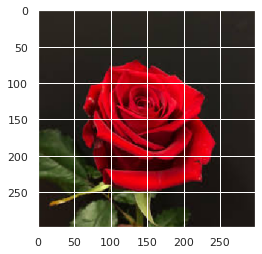

'rose'

In [ ]:
# download image from internet and test
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSV3_m8e8afFJJg3WZOWG72BdnuUeagfsdu_w&usqp=CAU"

image_url = tf.keras.utils.get_file(origin=url)
test_image = load_img(image_url, target_size=( 299, 299))
test_image = img_to_array(test_image)
test_image = test_image/255
plt.figure()
plt.imshow(test_image)
plt.show()
pred = cnn_model.predict(test_image.reshape(-1,299,299,3))
names[np.argmax(pred)]